In [ ]:
#import relevant libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.decomposition import PCA
from pathlib import Path
import scipy
import scipy.fftpack

In [ ]:
#This line of code ensures that same random number(s) are selected when called upon later on.
seed = np.random.seed(0)

__________________________________________________________________________________________________________________________________
Processing Raw Datasets

In [ ]:
#Reading in an example file of raw acoustic readings
#Converting the recorded date and time into a Python DateTime object
#Removing values in the acoustic reading that are invalid artifacts from the sensor
file = Path("/Users/jeansmith/Documents/WRF_DOE_DC_Water/DC_Water/Website/Raw_Acoustic_Example.csv")
df = pd.read_csv(file)
df['date'] = df['date'].astype(str)
df = df[df['date'] != 'nan']
df['date'] = [x.strip().replace('_', '-') for x in df["date"]]
df['time'] = df['time'].astype(str)
df = df[df['time'] != 'nan']
df['time'] = [x.strip().replace('_', ':') for x in df['time']]
df['DateTime'] = df['date']+" "+df['time']
df['DateTime'] = pd.to_datetime(df['DateTime'],dayfirst=True)
df.insert(0,'DateTime',df.pop('DateTime'))
df.drop(['date','time'],inplace=True, axis = 1)
df.drop(df.iloc[:, 12150:26201], axis = 1, inplace = True)
df.head()

,DateTime,1,2,3,4,5,6,7,8,9,...,12140,12141,12142,12143,12144,12145,12146,12147,12148,12149
0,2023-08-03 08:00:03,-0.898437,-0.467187,-2.012500,-1.437500,-2.048437,-1.401562,-2.084375,-1.653125,-1.221875,...,1.483033e-314,8.833712e-301,-1.395309e-45,0.0,1.526812e-308,1.579546e-314,8.833712e-301,-1.395309e-45,0.0,-1.395544e-45
1,2023-08-03 08:00:03,0.143750,-0.143750,-0.790625,0.107812,-0.215625,-1.473437,-0.718750,-1.293750,0.575000,...,1.483033e-314,8.833712e-301,-1.395309e-45,0.0,1.526812e-308,1.579546e-314,8.833712e-301,-1.395309e-45,0.0,-1.395544e-45
2,2023-08-03 08:00:03,0.826562,2.839062,1.437500,1.185938,1.329687,0.287500,1.509375,-0.179688,0.970313,...,1.483033e-314,8.833712e-301,-1.395309e-45,0.0,1.526812e-308,1.579546e-314,8.833712e-301,-1.395309e-45,0.0,-1.395544e-45
3,2023-08-03 08:05:03,-0.143750,2.479687,-1.293750,-0.143750,3.378125,2.731250,4.025000,2.587500,4.132812,...,1.483304e-314,4.794969e-303,-2.122812e-45,0.0,1.526812e-308,1.579475e-314,4.794969e-303,-2.122812e-45,0.0,-2.123283e-45
4,2023-08-03 08:05:03,-0.970313,0.143750,-0.287500,1.257812,-0.718750,0.898437,0.359375,-0.179688,-0.503125,...,1.483304e-314,4.794969e-303,-2.122812e-45,0.0,1.526812e-308,1.579475e-314,4.794969e-303,-2.122812e-45,0.0,-2.123283e-45


In [ ]:
#Defining a function that takes the FFT of the acoustic readings and scales it
def full_fft(raw_data, N):
    y = scipy.fftpack.fft(raw_data)
    y = (2.0/N)*np.abs(y[:N//2])
    return y

In [ ]:
#Taking the FFT of each measurement excluding the end of the signal containing artifacts from the sensor
i = 0
new_fft = []

while(i < len(df.index)):
    line = df.iloc[i][1:]
    time = df.iloc[i][0]

    fft = full_fft(line[0:11892], len(line[0:11892]))
    fft = list(fft)
    fft.insert(0, time)
    new_fft.append(fft)

    i = i + 1

df_fft = pd.DataFrame(new_fft)
step = (26200.0/2.0)/5946.0
cols = ['DateTime'] + [(i+1)*step for i in range(5946)]
df_fft.columns = cols
df_fft.head()

,DateTime,2.203161789438278,4.406323578876556,6.609485368314834,8.812647157753112,11.01580894719139,13.218970736629668,15.422132526067946,17.625294315506224,19.8284561049445,...,13080.171543895056,13082.374705684495,13084.577867473932,13086.781029263371,13088.98419105281,13091.187352842247,13093.390514631687,13095.593676421124,13097.796838210563,13100.000000000002
0,2023-08-03 08:00:03,0.128096,0.019693,0.012476,0.013447,0.001182,0.008098,0.017042,0.025470,0.362064,...,0.005192,0.003419,0.004270,0.003451,0.003736,0.002336,0.005071,0.003695,0.004134,0.006813
1,2023-08-03 08:00:03,0.139235,0.009587,0.008741,0.007793,0.022722,0.013750,0.021499,0.065852,0.390399,...,0.006557,0.007681,0.002965,0.007569,0.006228,0.008941,0.006872,0.003255,0.009540,0.002131
2,2023-08-03 08:00:03,0.074426,0.015501,0.005818,0.004056,0.018229,0.028147,0.019729,0.036953,0.378198,...,0.007848,0.004945,0.005181,0.006509,0.002130,0.005300,0.003848,0.008657,0.004773,0.006359
3,2023-08-03 08:05:03,0.162813,0.017651,0.010549,0.015069,0.016694,0.005804,0.006299,0.022425,0.258932,...,0.007835,0.009806,0.005351,0.004461,0.001452,0.004346,0.006075,0.007714,0.009153,0.008854
4,2023-08-03 08:05:03,0.085196,0.017842,0.003341,0.010605,0.018044,0.020570,0.009814,0.027969,0.257633,...,0.013602,0.003346,0.008936,0.008102,0.001081,0.009213,0.006927,0.009240,0.002229,0.003627


In [ ]:
#Defining a function to merge the acoustic profile dataset and the total solids laboratory measurements
#Converts the date and time values from the total solids dataset into Python DateTime objects
#Finds the acoustic measurements within 5 minutes of the sample being taken and appends the total solids value to a new dataframe
#with only the acoustic profiles matched with a total solids sample
def Acu_TS_merge(df, df_ts):

    df_ts['Date'] = df_ts['Date'].astype(str)
    df_ts = df_ts[df_ts['Date'] != 'nan']
    df_ts['Date'] = [x.strip().replace('/', '-') for x in df_ts["Date"]]
    df_ts['Time'] = df_ts['Time'].astype(str)
    df_ts['Time'] = [x.strip().replace('_', ':') for x in df_ts['Time']]
    df_ts['DateTime'] = df_ts['Date']+" "+df_ts['Time']
    df_ts['DateTime'] = pd.to_datetime(df_ts['DateTime'],dayfirst=False)
    df_ts.insert(0,'DateTime',df_ts.pop('DateTime'))
    df_ts.drop(['Date','Time'],inplace=True, axis = 1)

    df['DateTime'] = pd.to_datetime(df['DateTime'])

    df_ts.sort_values("DateTime", inplace=True)
    df.sort_values("DateTime",inplace=True)
    df_merged = pd.merge_asof(df, df_ts, on="DateTime", direction="nearest",
                              tolerance = pd.Timedelta(5, "minute"))
    df_merged = df_merged[df_merged['Location'].notna()]
    df_merged.reset_index(inplace = True)

    return df_merged

In [ ]:
#Defining a function that averages the acoustic profiles taken at the same time as measurements were taken in triplicate
def average_filtered_samples(df):
    errors = []
    df = df.sort_values(by = 'DateTime')

    avg_df = []
    i = 0
    while(i < len(df.index)):
        df_mean = [df.iloc[i, 1], df.iloc[i, -2]]
        df_3 = df[i:i+3][:]
        df_3.drop(['index','TS', 'DateTime', 'Location'], inplace = True, axis = 1)
        df_mean_1 = df_3.mean()
        df_mean_1 = list(df_mean_1)
        df_mean = df_mean + df_mean_1
        avg_df.append(df_mean)
        i = i + 3

    avg_df = pd.DataFrame(avg_df)

    return errors, avg_df

In [ ]:
#Reading in the total solids measurements
#Merging the acoustic and total solids dataset
#Averaging the samples
df_ts = pd.read_csv("/Users/jeansmith/Documents/WRF_DOE_DC_Water/DC_Water/Website/Raw_Total_Solids_Example.csv")
df_merged = Acu_TS_merge(df_fft, df_ts)
errors, avg_df = average_filtered_samples(df_merged)
step = (26200.0/2.0)/5946.0
cols = ['DateTime'] + ['TS'] + [(i+1)*step for i in range(5946)]
avg_df.columns = cols
avg_df.head()

,DateTime,TS,2.203161789438278,4.406323578876556,6.609485368314834,8.812647157753112,11.01580894719139,13.218970736629668,15.422132526067946,17.625294315506224,...,13080.171543895056,13082.374705684495,13084.577867473932,13086.781029263371,13088.98419105281,13091.187352842247,13093.390514631687,13095.593676421124,13097.796838210563,13100.000000000002
0,2023-08-03 08:00:03,11.05,0.113919,0.014927,0.009012,0.008432,0.014044,0.016665,0.019423,0.042758,...,0.006532,0.005348,0.004139,0.005843,0.004031,0.005526,0.005264,0.005202,0.006149,0.005101
1,2023-08-03 08:05:03,10.89,0.125695,0.027861,0.016774,0.017023,0.023768,0.019783,0.016675,0.033071,...,0.008670,0.008326,0.009817,0.006530,0.001970,0.006242,0.006134,0.007740,0.006086,0.006082
2,2023-08-03 08:10:04,10.89,0.120904,0.017654,0.012810,0.012327,0.014593,0.011606,0.019353,0.031929,...,0.004562,0.005588,0.006094,0.008247,0.006471,0.006880,0.006935,0.007226,0.003786,0.004198
3,2023-08-03 08:15:03,13.68,0.111582,0.015684,0.016214,0.021244,0.015397,0.020478,0.039510,0.012646,...,0.002754,0.004255,0.004058,0.007726,0.003494,0.007239,0.007040,0.003975,0.007946,0.003804
4,2023-08-03 08:20:04,13.68,0.120275,0.021536,0.011088,0.012428,0.011906,0.012943,0.039500,0.025429,...,0.001110,0.001706,0.001246,0.001502,0.001355,0.001212,0.001598,0.001508,0.002316,0.000998


In [ ]:
#Defining a function to merge flow variables with the TS/Acoustic dataset
#Converting the flow date value into a Python DateTime object
#Identifying the flow value within 30 seconds of the acoustic measurement and appending that to the dataframe
def Acu_Flow_Merge(df, df_flow):

    df['DateTime'] = pd.to_datetime(df['DateTime'])

    df_flow = df_flow.drop_duplicates(keep = 'first', ignore_index = True)
    df_flow['DateTime'] = df_flow['DateTime'].astype(str)
    df_flow = df_flow[df_flow['DateTime'] != 'nan']
    df_flow['DateTime'] = [x.strip().replace('/', '-') for x in df_flow["DateTime"]]

    df_flow['DateTime'] = pd.to_datetime(df_flow['DateTime'],dayfirst=False);
    df_flow.sort_values("DateTime",inplace=True)

    df_filtered = pd.merge_asof(df,df_flow, left_on="DateTime",right_on="DateTime",direction="nearest",
                               tolerance = pd.Timedelta(30, "second"))


    df_filtered.insert(1,'Flow',df_filtered.pop('THP DIG 3 FD CTL 1 FLOW'))
    df_filtered.insert(2,'Enable',df_filtered.pop('DIG 3 CSLDS PMP 1  RUNST'))
    df_filtered.insert(3, 'Flow Smooth', df_filtered.pop('Flow Smooth 1'))
    return df_filtered

In [ ]:
#Reading the flow measurement into a dataframe
#Smoothing the flow with a moving average smoothing algorithm with a width of 21 steps
df_flow = pd.read_csv("/Users/jeansmith/Documents/WRF_DOE_DC_Water/DC_Water/Website/Raw_Flow_Example.csv")

width_half = 10
width = (width_half*2) + 1

raw = df_flow['THP DIG 3 FD CTL 1 FLOW'].values
smooth = []

j = 0
while(j < width_half):
    smooth.append(0)
    j = j + 1

smooth.append((np.mean(raw[0:width])))
i = width_half + 1
while(i < (len(raw)-width_half)):
    smooth.append(smooth[-1] + (raw[i+width_half]/width) - (raw[i-width_half-1]/width))
    i = i + 1

j = 0
while(j < width_half):
    smooth.append(0)
    j = j + 1

df_flow['Flow Smooth 1'] = smooth

df_flow.head()

,DateTime,THP DIG 3 FD CTL 1 FLOW,DIG 3 CSLDS PMP 1 RUNST,Flow Smooth 1
0,08/03/2023 00:00:00,92.19,1.0,0.0
1,08/03/2023 00:01:00,86.93,1.0,0.0
2,08/03/2023 00:02:00,62.15,1.0,0.0
3,08/03/2023 00:03:00,49.43,1.0,0.0
4,08/03/2023 00:04:00,45.60,1.0,0.0


In [ ]:
#Merging the flow data with the total solids/acoustic dataset
df_filtered = Acu_Flow_Merge(avg_df, df_flow)

________________________________________________________________________________________________________________________
Modelling with complete dataset

In [ ]:
#Reading the complete, merged dataset in to be used in the final model
data = pd.read_csv("/Users/jeansmith/Documents/WRF_DOE_DC_Water/DC_Water/Website/Final_Digester_Dataset_Example.csv") #data is imported under the variable data
data.head()

,DateTime,Flow,Enable,Flow Smooth,TS,2.203161789438278,4.406323578876556,6.609485368314834,8.812647157753112,11.01580894719139,...,13080.171543895056,13082.374705684495,13084.577867473932,13086.781029263371,13088.98419105281,13091.187352842247,13093.390514631687,13095.593676421124,13097.796838210563,13100.000000000002
0,2023-05-30 09:15:04,80.66,1.0,80.449524,9.85,0.228233,0.228196,0.228159,0.228121,0.228084,...,0.004708,0.004913,0.005119,0.005324,0.005464,0.005586,0.005709,0.005831,0.005954,0.006077
1,2023-05-30 09:20:03,81.62,1.0,80.007619,9.85,0.323992,0.323938,0.323884,0.323830,0.323776,...,0.004362,0.004300,0.004238,0.004175,0.004020,0.003841,0.003661,0.003481,0.003301,0.003121
2,2023-05-30 09:25:04,79.78,1.0,79.531429,11.16,0.199591,0.199558,0.199526,0.199493,0.199461,...,0.006826,0.006922,0.007019,0.007116,0.007003,0.006834,0.006664,0.006495,0.006326,0.006156
3,2023-05-30 09:30:03,74.38,1.0,79.340000,11.16,0.228028,0.227991,0.227954,0.227916,0.227879,...,0.004579,0.004685,0.004790,0.004896,0.004980,0.005059,0.005138,0.005217,0.005296,0.005375
4,2023-05-30 09:35:03,81.63,1.0,78.730952,10.90,0.236527,0.236489,0.236450,0.236412,0.236373,...,0.006432,0.006515,0.006598,0.006681,0.006814,0.006960,0.007105,0.007251,0.007397,0.007543


In [ ]:
#Separating the input data into vectors
#Creating an X and y dataset in typical machine learning format
DateTime = data['DateTime'].values
Flow = data['Flow'].values
Enable = data['Enable'].values
Flow_Smooth = data['Flow Smooth'].values

y = data['TS'].values #y stores the values of column TS
X = data.drop(['DateTime','Flow','Enable','Flow Smooth','TS'], axis=1).values #X stores the values of data except for TS

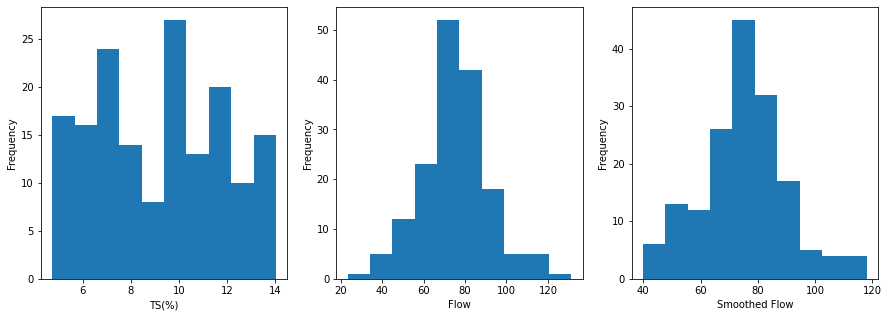

In [ ]:
#Plotting the ranges of total solids and flow observed in the dataset
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.hist(y);
ax1.set_xlabel("TS(%)");
ax1.set_ylabel("Frequency");

ax2.hist(Flow);
ax2.set_xlabel("Flow");
ax2.set_ylabel("Frequency");

ax3.hist(Flow_Smooth);
ax3.set_xlabel("Smoothed Flow");
ax3.set_ylabel("Frequency");

In [ ]:
#Smoothing the acoustic data with a moving average with a window of 21 steps
width_half = 10

width = 2*width_half + 1

X_smooth = []

for raw in X:
    smooth = []
    smooth.append(np.mean(raw[0:(width)]))
    i = width_half + 1
    while(i < (len(raw)-width_half)):
        smooth.append(smooth[-1] + (raw[i+width_half]/width) - (raw[i-width_half-1]/width))
        i = i + 1

    X_smooth.append(smooth)

X_smooth = np.array(X_smooth)


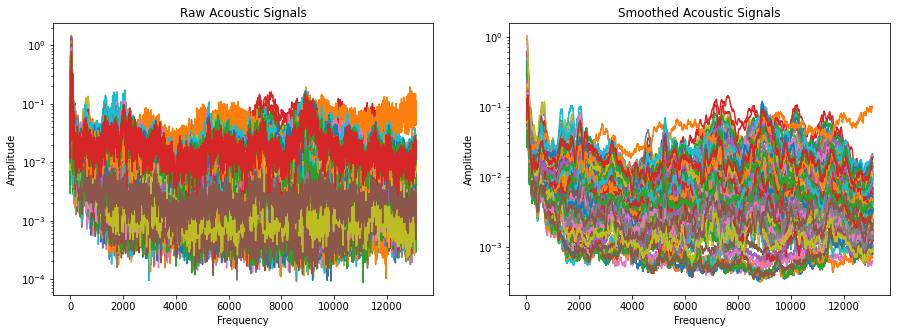

In [ ]:
#Plotting the regular acoustic FFT data and the smoothed dataset
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

step = (26200.0/2.0)/5946.0
xaxis = [(i+1)*step for i in range(5946)]

ax1.plot(xaxis, np.transpose(X));
ax1.set_yscale("log");
ax1.set_xlabel("Frequency");
ax1.set_ylabel("Amplitude");
ax1.set_title("Raw Acoustic Signals");

ax2.plot(xaxis[10:5936], np.transpose(X_smooth));
ax2.set_yscale("log");
ax2.set_xlabel("Frequency");
ax2.set_ylabel("Amplitude");
ax2.set_title("Smoothed Acoustic Signals");

In [ ]:
#The machine learning dataset is chosen as the smoothed acoustic dataset
#X is split into training(80% of original) and testing(20% of original) datasets
#Principal component analysis is fit and used to transform the dataset into 20 features
X = X_smooth

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1104)

pca = PCA(n_components=20)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Root Mean Squared Error (Average Model): 2.7282542695469765


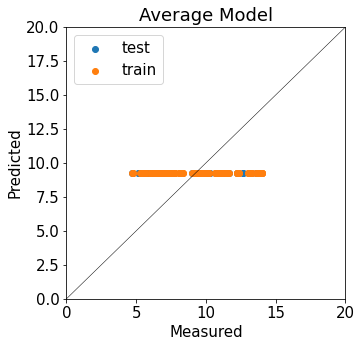

In [ ]:
#The average model of the data is plot
#The average model predicts the mean of the training y values for every training point
calc_mean=np.mean(y_train)
n=len(y_test)
y_pred_list_mean=[calc_mean]*n
y_pred_mean=np.array(y_pred_list_mean)
y_pred_list_train = [calc_mean]*len(y_train)
y_pred_mean_train = np.array(y_pred_list_train)

rmse_mean=np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean))

print('Root Mean Squared Error (Average Model):', rmse_mean)

plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15});
plt.scatter(y_test, y_pred_mean,label="test")
plt.scatter(y_train, y_pred_mean_train,label="train")
plt.legend()
plt.xlim([0,20]);
plt.ylim([0,20]);
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.axline([0, 0], [1, 1],color = 'black', linewidth = 0.5)
plt.title('Average Model');

Root Mean Squared Error (Linear Regression): 1.2995166464188683


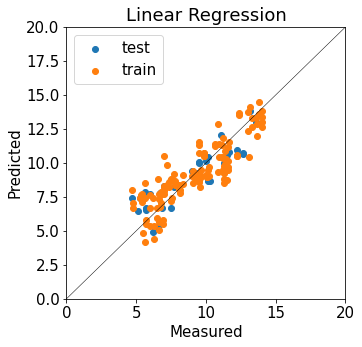

In [ ]:
#Linear Regression is plot
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Root Mean Squared Error (Linear Regression):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15});
plt.scatter(y_test, y_pred,label="test")
plt.scatter(y_train, regressor.predict(X_train),label="train")
plt.legend()
plt.xlim([0,20]);
plt.ylim([0,20]);
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.axline([0, 0], [1, 1],color = 'black', linewidth = 0.5)
plt.title('Linear Regression');

Root Mean Squared Error (Xgboost):  1.6325682952170941


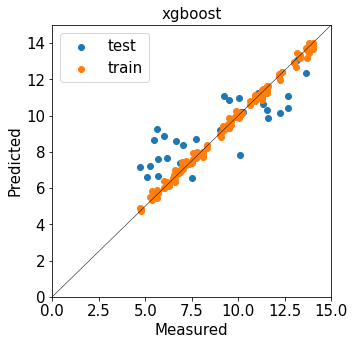

In [ ]:
#XGBoost is plot
regr = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=1.5, n_estimators=7200,
                        reg_alpha=0.9, reg_lambda=0.6, subsample=0.2, seed=42)#, silent=1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("Root Mean Squared Error (Xgboost): ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15});
plt.scatter(y_test, y_pred,label="test")
plt.scatter(y_train, regr.predict(X_train),label="train")
plt.legend()
plt.xlim([0,20]);
plt.ylim([0,20]);
plt.xlabel('Measured', fontsize=15)
plt.ylabel('Predicted', fontsize=15)
plt.axline([0, 0], [1, 1],color = 'black', linewidth = 0.5)
plt.xlim([0,15])
plt.ylim([0,15])

plt.title("xgboost",fontsize=15);

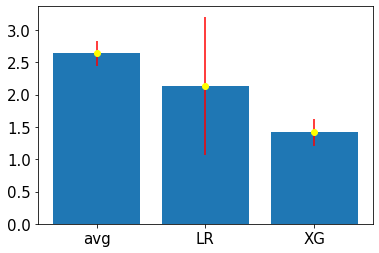

In [ ]:
#Cross Validation

rmse_list_avg=[]
rmse_list_LR=[]
rmse_list_XG=[]
for i in range (50):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=i)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    y_test_list=y_test.tolist()
    y_train_list=y_train.tolist()
    calc_mean=np.mean(y_train_list)
    n=len(y_test)
    y_pred_list_mean=[calc_mean]*n
    y_pred_mean=np.array(y_pred_list_mean)

    #y_pred
    rmse_mean=np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean))
    rmse_list_avg.append(rmse_mean)

    #LR
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    rmse_list_LR.append(np.sqrt(metrics.mean_squared_error(y_test, regressor.predict(X_test))))

    #XG
    regr = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=1.5, n_estimators=7200,
                            reg_alpha=0.9, reg_lambda=0.6, subsample=0.2, seed=42)#, silent=1)
    regr.fit(X_train, y_train)
    rmse_list_XG.append(np.sqrt(metrics.mean_squared_error(y_test, regr.predict(X_test))))

x= ['avg','LR','XG']
y_=[np.mean(rmse_list_avg),np.mean(rmse_list_LR), np.mean(rmse_list_XG)]
y_error = [np.std(rmse_list_avg), np.std(rmse_list_LR), np.std(rmse_list_XG)]

plt.bar(x,y_)

# Plot error bar

plt.errorbar(x, y_, yerr = y_error,fmt='o',ecolor = 'red',color='yellow')

# Display graph

plt.show()

,Actual,Predicted
0,4.72,6.653510
1,7.46,7.714583
2,6.80,5.913671
3,6.68,10.274941
4,8.10,6.397777
5,9.47,9.798674
6,11.26,7.428153
7,10.65,8.829740
8,12.37,12.495289
9,9.50,9.388851


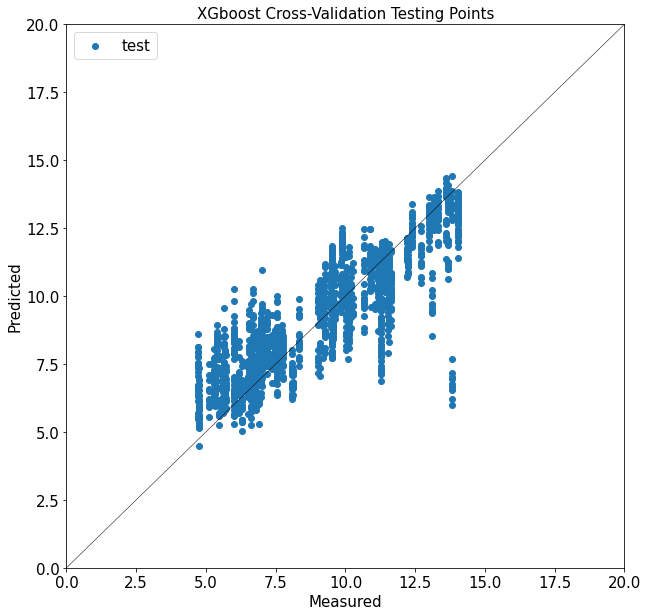

In [ ]:
#The training predictions for every iteration of cross-validation of XGBoost are plotted
#Compare to the 1:1 line to determine if XGBoost is predicting a pattern or if it is predicting the mean
y_test_vec = []
y_pred_vec = []
y_train_vec = []
y_train_pred_vec = []
for i in range (50):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=i)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    regr = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=1.5,
                            n_estimators=7200, reg_alpha=0.9, reg_lambda=0.6, subsample=0.2, seed=42)#, silent=1)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    y_test_vec.append(y_test)
    y_pred_vec.append(y_pred)
    y_train_vec.append(y_train)
    y_train_pred_vec.append(regr.predict(X_train))

plt.figure(figsize=(10,10))
plt.scatter(y_test_vec, y_pred_vec,label="test")
plt.legend()
plt.xlabel('Measured', fontsize=15)
plt.ylabel('Predicted', fontsize=15)
plt.axline([0, 0], [1, 1],color = 'black', linewidth = 0.5)
plt.xlim([0,20])
plt.ylim([0,20])

plt.title("XGboost Cross-Validation Testing Points",fontsize=15)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head(20)